## Step 4 - Global Interpretability

In this first part, we aim to interpret our blackbox model globally :
 
1. By implementing one surrogate method to interpret our black-box model
2. By implementing two other post-hoc global methods (PDP, ALE, etc) to interpret your black-box model. 
3. We finally compare then compare the two sets of results, blackbox and whitebox model


In [1]:
pip install -r ../requirements.txt

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.2.2 -> 23.3.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import statements
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from sklearn.tree import plot_tree
from pygam import LogisticGAM, s,  f
from hyperopt import fmin, tpe, hp, Trials
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

### 1. Implementing a Surrogate model to interpret our blackbox model 


#### A. Loading the Catboost model

In [14]:
# Load dataset
df = pd.read_csv('../Dataset/df_processed.csv')
X = df.drop('Grade', axis=1).copy()
y = df['Grade'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Load the model from the file
model_filename = '../Models/blackbox_model.pkl'
blackbox_model = joblib.load(model_filename)
y_pred_blackbox = blackbox_model.predict(X_test)

In [15]:
blackbox_model.get_params()

{'iterations': 900,
 'learning_rate': 0.03928392507108075,
 'depth': 7,
 'l2_leaf_reg': 4,
 'verbose': 0,
 'cat_features': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}

#### B. Implementing and Saving the surrogate model: Tuned decision tree

We chose to implement a decision tree model with tuned parameters, for the following reasons: 
- it's very easy to interpret, and by plotting the decision logic in the form of a binary tree, we understand what the decision logic behind the model is.
- the catboost model is also a tree-based model, so it's legitimate to choose a surrogate model based on decision tree logic.

Furthermore, we note that our blackbox model has a feature depth of 7, so we arbitrarily choose to set the depth of our surrogate decision tree model also to 7 so that it best explains the performance of our catboost blackbox model.

In [5]:
# Load dataset
df = pd.read_csv('../Dataset/df_processed.csv')
X = df.drop('Grade', axis=1).copy()
y = df['Grade'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Apply a numerical mapping for categorical columns
categorical_mapping = {
    'Gender': {'female': 0, 'male': 1},
    'EthnicGroup': {'group A': 0, 'group B': 1, 'group C': 2, 'group D': 3, 'group E': 4},
    'ParentEduc': {'some high school': 0, 'high school': 1, "associate's degree": 2, 'some college': 3, "bachelor's degree": 4, "master's degree": 5},
    'LunchType': {'standard': 0, 'free/reduced': 1},
    'ParentMaritalStatus': {'widowed': 0, 'divorced': 1, 'single': 2, 'married': 3},
    'PracticeSport': {'sometimes': 0, 'regularly': 1, 'never': 2},
    'WklyStudyHours': {'Less than 5 hours': 0, 'Between 5-10 hours': 1, 'More than 10 hours': 2}
}

columns_to_map = list(categorical_mapping.keys())
X_train[columns_to_map] = X_train[columns_to_map].replace(categorical_mapping)
X_test[columns_to_map] = X_test[columns_to_map].replace(categorical_mapping)

In [6]:
# Objective function to minimize
def objective(params):
    decision_tree = DecisionTreeClassifier(
        random_state=42,
        min_samples_leaf=params['min_samples_leaf'],
        max_leaf_nodes=params['max_leaf_nodes'],
        min_samples_split=params['min_samples_split'],
        min_weight_fraction_leaf=params['min_weight_fraction_leaf'],
    )
    score = -cross_val_score(decision_tree, X_train, y_train, cv=5, scoring='accuracy').mean()
    return score

# Space for hyperparameters gridsearch
space = {
    'min_samples_leaf': hp.randint('min_samples_leaf', 1, 11),
    'max_leaf_nodes': hp.randint('max_leaf_nodes', 2, 100),
    'min_samples_split': hp.randint('min_samples_split', 2, 21),
    'min_weight_fraction_leaf': hp.uniform('min_weight_fraction_leaf', 0.0, 0.5),
}

trials = Trials()
best = fmin(fn=objective, 
            space=space, 
            algo=tpe.suggest, 
            max_evals=400, 
            trials=trials, 
            rstate=np.random.default_rng(seed=42))

print("Best Hyperparameters:", best)

best_min_samples_leaf = int(best['min_samples_leaf'])
best_max_leaf_nodes = int(best['max_leaf_nodes'])
best_min_samples_split = int(best['min_samples_split'])
best_min_weight_fraction_leaf = best['min_weight_fraction_leaf']

# Fit the model and make predictions
best_decision_tree = DecisionTreeClassifier(
    random_state=42,
    max_depth=7, # Set to 7 as our black-box catboost model
    min_samples_leaf=best_min_samples_leaf,
    max_leaf_nodes=best_max_leaf_nodes,
    min_samples_split=best_min_samples_split,
    min_weight_fraction_leaf=best_min_weight_fraction_leaf,
)
best_decision_tree.fit(X_train, y_train)
y_test_pred = best_decision_tree.predict(X_test)

# Calculate evaluation metrics
accuracy_surrogate = accuracy_score(y_test, y_test_pred)
precision_surrogate = precision_score(y_test, y_test_pred)
recall_surrogate = recall_score(y_test, y_test_pred)
f1_surrogate = f1_score(y_test, y_test_pred)

print('Accuracy test score : ', np.round(accuracy_surrogate, 4)*100, '%')
print('Precision test score : ', np.round(precision_surrogate, 4)*100, '%')
print('Recall test score : ', np.round(recall_surrogate, 4)*100, '%')
print('F1 test score : ', np.round(f1_surrogate, 4)*100, '%')


100%|██████████| 400/400 [00:22<00:00, 17.90trial/s, best loss: -0.7656657758965989]
Best Hyperparameters: {'max_leaf_nodes': 56, 'min_samples_leaf': 5, 'min_samples_split': 13, 'min_weight_fraction_leaf': 0.007919577491601416}
Accuracy test score :  76.51 %
Precision test score :  56.53 %
Recall test score :  20.979999999999997 %
F1 test score :  30.599999999999998 %


In [18]:
# Saving the surrogate model 
model_filename = '../Models/surrogate_model.pkl'
joblib.dump(best_decision_tree, model_filename)

['../Models/surrogate_model.pkl']

#### C. Using Surrogate model 1 and 2 to interpret Black-box model

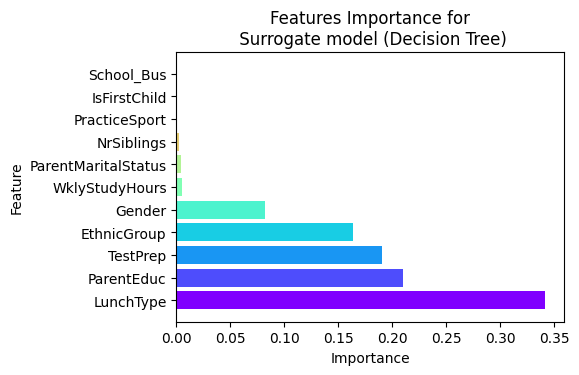

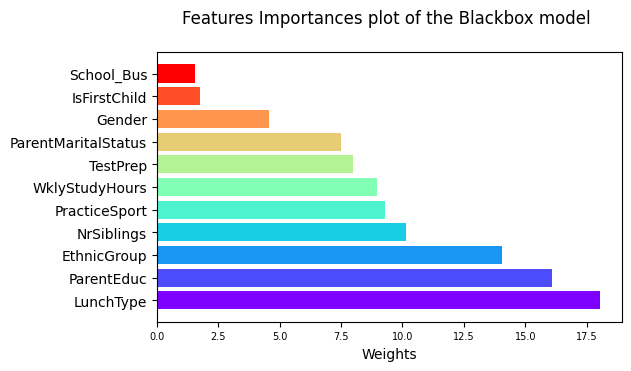

In [16]:
# Get feature importances from the best_decision_tree model
feature_importances = best_decision_tree.feature_importances_
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances for the top 10 features
colors = cm.rainbow(np.linspace(0, 1, len(importance_df)))
plt.figure(figsize=(5, 3.5))
plt.barh(importance_df['Feature'], importance_df['Importance'], color=colors)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Features Importance for\n Surrogate model (Decision Tree)')
plt.show()

# Features Importance plot du blackbox model
columns_names = X.columns.to_list()
weights_blackbox = blackbox_model.feature_importances_
indices = np.argsort(weights_blackbox)[::-1]
sorted_weights = [weights_blackbox[i] for i in indices]
sorted_columns = [columns_names[i] for i in indices]

# Create the figure
plt.figure(figsize=(6, 3.5))
colors = plt.get_cmap("rainbow")(np.linspace(0, 1, len(sorted_columns)))
plt.barh(sorted_columns, sorted_weights, color=colors)
plt.xticks(fontsize=7)  
plt.xlabel('Weights')
plt.title('Features Importances plot of the Blackbox model \n')
plt.show()

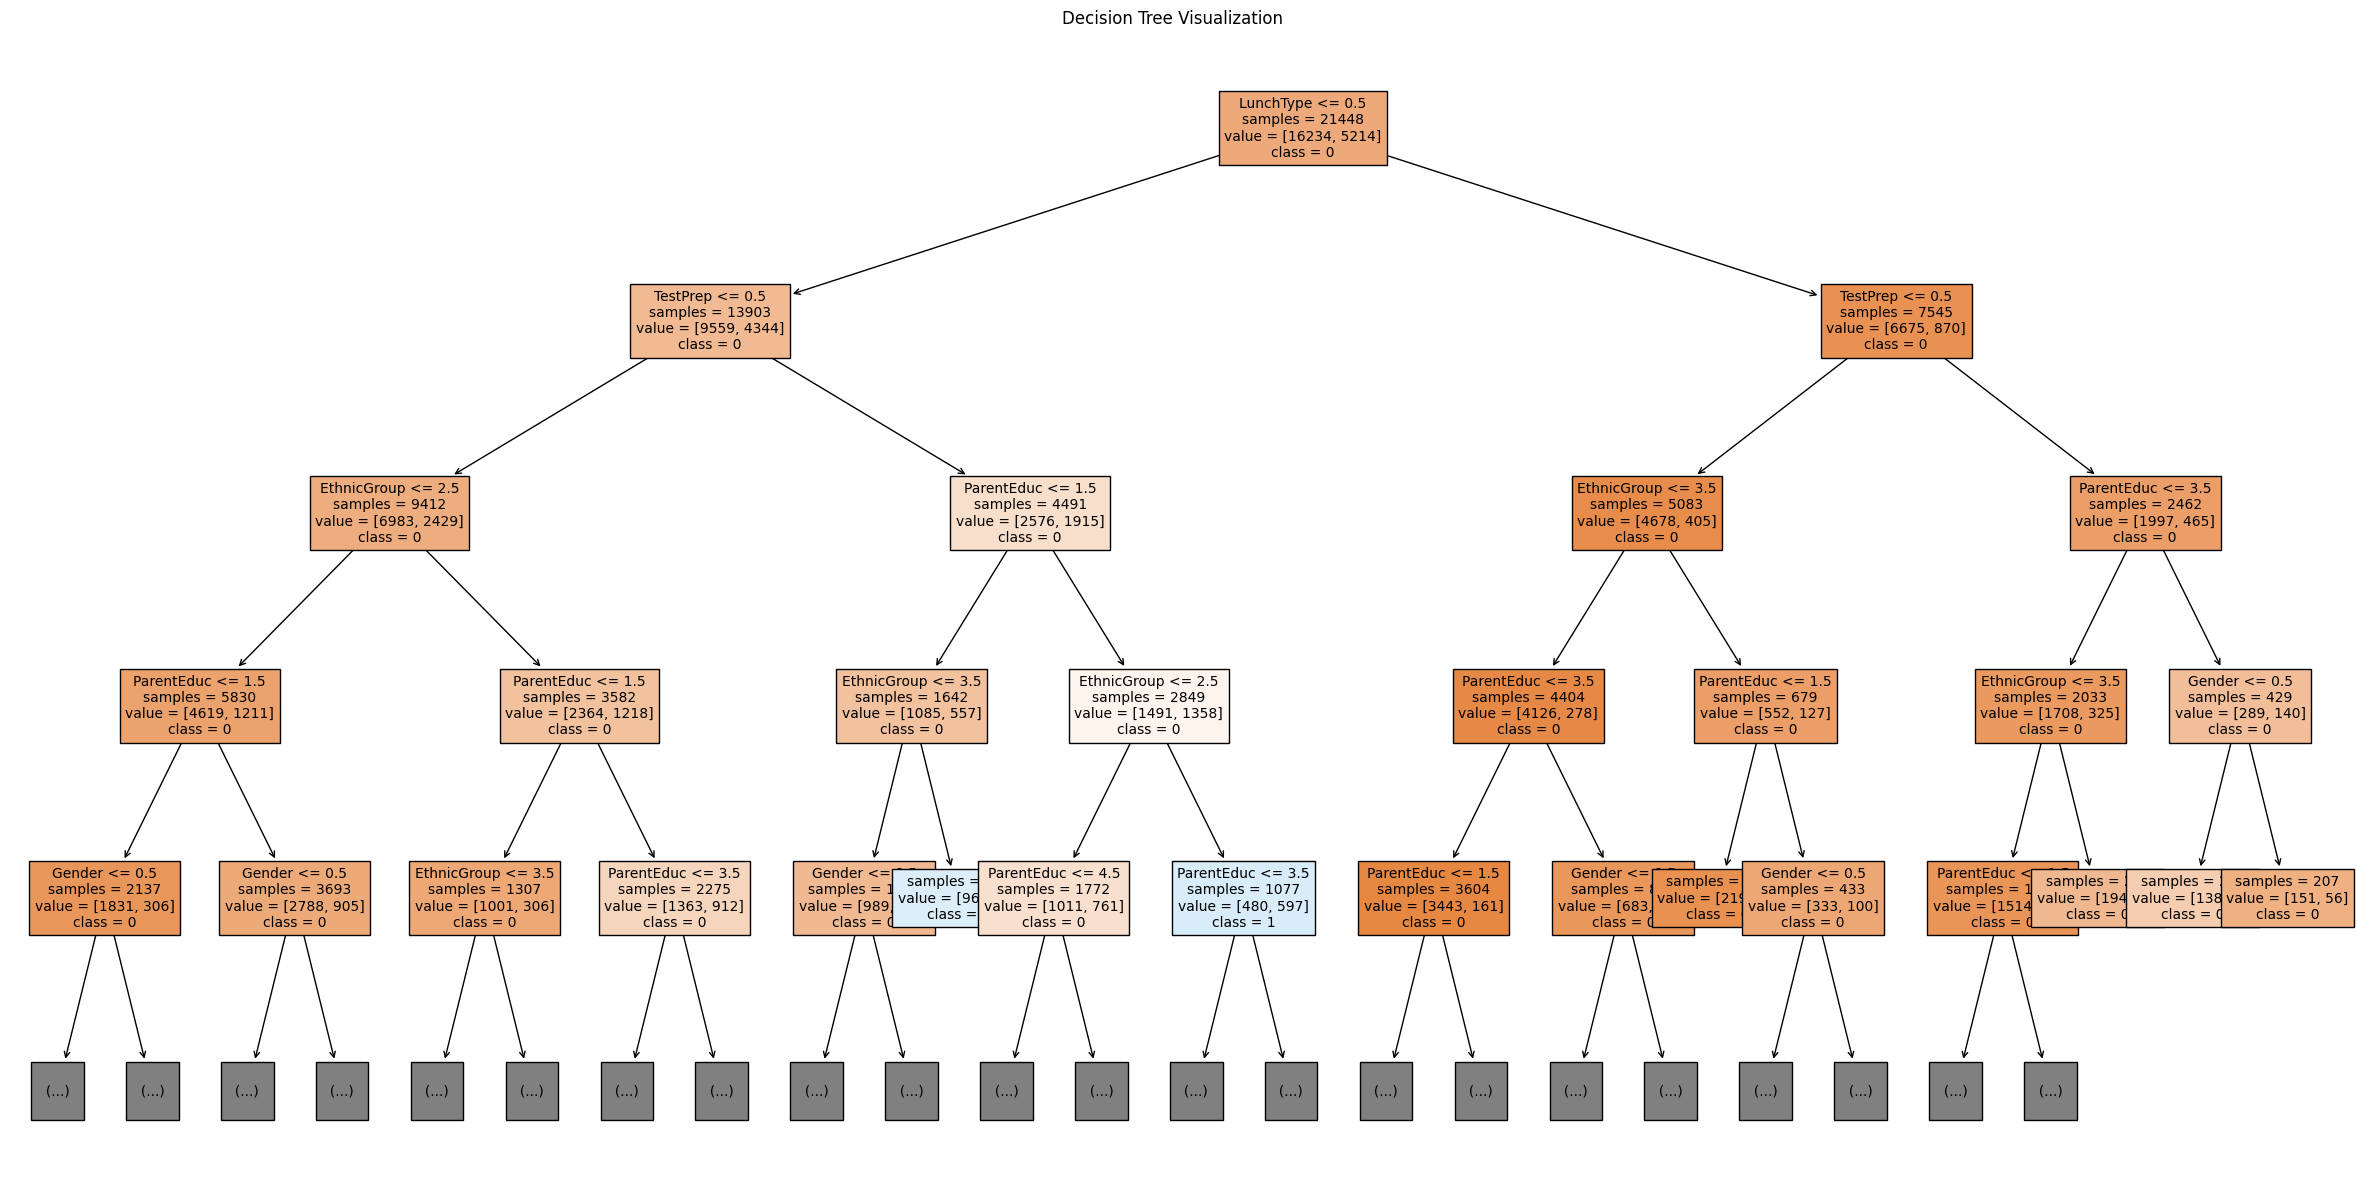

In [23]:
# Decision Tree logic plot  
plt.figure(figsize=(30, 15)) 
plot_tree(
    best_decision_tree,
    max_depth=4,
    filled=True,
    feature_names=X_train.columns.tolist(),
    class_names=['0', '1'],
    fontsize=10,  
    impurity=False  
)
plt.title("Decision Tree Visualization")
plt.show()

The results are fairly consistent: 

As we set the maxdepth of the surrogate model to 7, the decision tree evaluates the three variables School_Bus, isFirstChild and PracticeSport as insignificant (no associated coefficient). The blackbox model is fairly consistent on this point, rating School_Bus and isFirstChild as the two variables with the least impact on the result. However, it places the variable PracticeSport as the 5th variable with the highest weight, which can't quite be explained by our algorithm. When using logic, it's not easy to decide whether or not this variable is impactful, as we know that sport can both be very beneficial for achieving greater efficiency at work, but can also be considered time-consuming and therefore reduce the time allocated to revision. So the link isn't necessarily direct, and it's hard to interpret this contrary result between the black-box and surrogate model.

Apart from that, it's good to see that the most impactful features of the decision tree model (surrogate model) are found in the most important features of the Catboost black-box model: **LunchType**, **ParentEduc** and **TestPrep** are among the most impactful feautres.

It's pretty much in line with what we've been thinking: lunchType inevitably impacts the quality of students' work (those who eat at the canteen certainly save themselves commuting time and therefore have more time to work). Parents with a higher level of education certainly encourage their children to work harder. And finally, those with 1 in TestPrep are obviously more prepared, which may justify higher marks.

However, the decision tree is rather limited because, as we said earlier, it is quite prone to overfitting and will not give the same results depending on the training dataset. It may therefore be interesting to interpret our black-box model using our white-box model defined in part 3, the tuned GAM model, which can also act as an overrogate model.

In [25]:
# Load the model from the file
model_filename = '../Models/whitebox_model.pkl'
whitebox_model = joblib.load(model_filename)
whitebox_model

LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=f(0) + f(1) + f(2) + f(3) + f(4) + f(5) + f(6) + f(7) + s(8) + f(9) + f(10) + intercept,
   tol=0.0001, verbose=False)

In [26]:
whitebox_model.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     24.2638
Link Function:                        LogitLink Log Likelihood:                                 -10205.166
Number of Samples:                        21448 AIC:                                            20458.8595
                                                AICc:                                           20458.9215
                                                UBRE:                                               2.9548
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.1419
Feature Function                  Lam

/var/folders/h7/_dgsjjs93hv7lr5ql2ffz2_c0000gn/T/ipykernel_27384/3080492088.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  whitebox_model.summary()


Interestingly, the GAM model judges 4 features as insignificant (i.e. with a p-value greater than 5%): 
- f(5) : ParentMaritalStatus
- f(7) : IsFirstChild
- s(8) : NrSiblings
- f(9) : School_Bus

These results fully confirm the results of the first surrogate model, the decision tree, which considers these three features to have the least impact on predictions.

### 2. Implementing two other post-hoc global methods (PDP, ALE) to interpret Black-box model

##### A. Partial Dependency Plots

<Figure size 640x480 with 0 Axes>

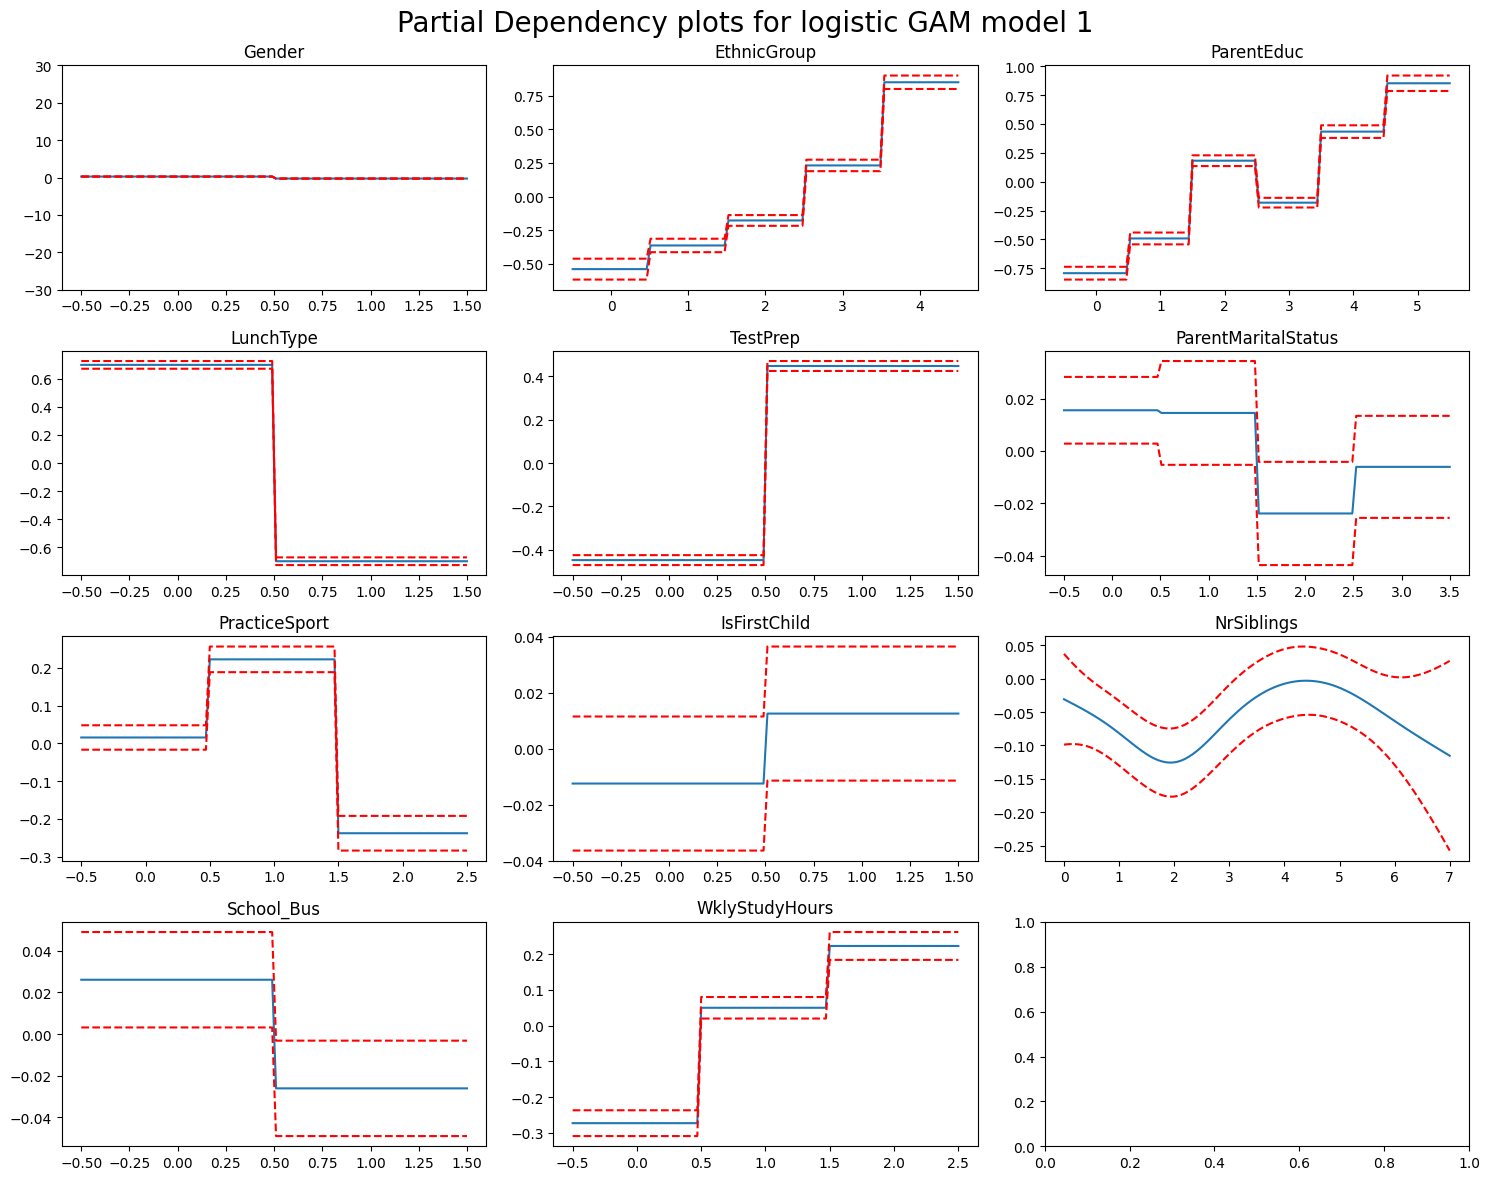

In [29]:
# Plot partial dependency plots
titles = X_train.columns[0:11]
plt.figure()

fig, axs = plt.subplots(4, 3, figsize=(15, 12))  
for i, ax in enumerate(axs.flatten()):
    if i < 11:  
        XX = whitebox_model.generate_X_grid(term=i)
        ax.plot(XX[:, i], whitebox_model.partial_dependence(term=i, X=XX))
        ax.plot(XX[:, i], whitebox_model.partial_dependence(term=i, X=XX, width=0.8)[1], c='r', ls='--')
        if i == 0:
            ax.set_ylim(-30, 30)
        ax.set_title(titles[i])

plt.suptitle('Partial Dependency plots for logistic GAM model 1', fontsize=20)
plt.subplots_adjust(top=1) 
plt.tight_layout()
plt.show()


These partial dependency plots fully confirm the results of the first surrogate model, the decision tree.

For features that were judged as non-impactful by the decision tree model, the partial dependency plots obtained using our GAM whitebox model validate the results. The variables ParentMaritalStatus (f(5)) and NrSiblings (s(8)) take on several values, but the factor function and spline function applied to them show a smooth function that indicates no positive or negative correlation between the number of siblings and test success. 

Similarly, the Partial Dependency Plot of parents' marital status represents a step function that indicates no clear correlation between this feature and the student's academic success. Finally, for the IsFirstChild and School_Bus variables, which are also step functions, we have distinct steps but obviously very large standard deviations, demonstrating that the impact of these features on the variable of interest is not clear-cut. 

Apart from that, the other features are also step functions, but the impact seems quite clear, associated with very low standard deviations.

##### B. ALE plots 

### 3. Compare Surrogate model performance with Black-box model

In [31]:
# Load dataset
df = pd.read_csv('../Dataset/df_processed.csv')
X = df.drop('Grade', axis=1).copy()
y = df['Grade'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Load the model from the file
model_filename = '../Models/blackbox_model.pkl'
blackbox_model = joblib.load(model_filename)
y_pred_blackbox = blackbox_model.predict(X_test)
y_pred_blackbox_train = blackbox_model.predict(X_train)